### 迷惑パラメータと周辺された分布

私たちが興味を持つモデルは、ほとんどの場合、複数のパラメータを持っています。モデルを構築するために必要なパラメータは、直接的に関心の無いものが含まれこともあります。つまり、あるパラメータについて、本当は関心がないとしても、モデルを構築するためにそのパラメータを必要に迫られて追加することがあります。私たちが関心している重要な問題に答えるために、正規分布の平均値を推定する必要があるとしましょう。このようなモデルに置いて、正規分布の標準偏差の値が未知である場合、標準偏差に関心がなくても、その値を推定しなければなりません。このようなパラメータを迷惑パラメータと言われます。ベイジアンパラダイムのもとでは、任意の未知なる数量は、全て同じように扱われます。

このような迷惑パラメータをモデルに含まれることによって、不確実性を吸収させることができます。

二つのパラメターたを持つベイズのていりは、次のように書くことができます。３つ以上のパラメータも拡張可能です。

$
p (\theta_1, \theta_2 | y) \propto p(y | \theta_1, \theta_2)p(\theta_1, \theta_2)
$

多数のパラメータを持つ場合と今までの単一パラメータと異なる一つ目の点は、$\theta_1, \theta_2$の同時分布を示す2次元の事後分布を持つということです。さて、$\theta_2$を迷惑パラメータとすると、

$
p(\theta_1|y) = \int p(\theta_1, \theta_2|y)d\theta_2
$

これは$\theta_2$の不確実性を暗黙的に考慮にいれることです。

<AxesSubplot:ylabel='Density'>

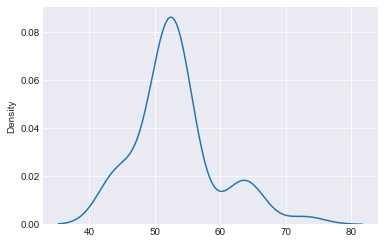

In [4]:
import seaborn as sns
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

data = np.array([51.06, 54, 64, 44, 54, 53, 52,51.06, 62, 73,
                51.06, 54, 64, 44, 54, 53, 52,51.06,
                51.06, 54, 64, 44, 54, 53, 52,51.06,
                51.06, 54, 64, 44, 54, 53, 52,51.06,51.06, 54, 64, 44, 54, 53, 52,51.06, 45, 46])

sns.kdeplot(data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_100 draw iterations (4_000 + 4_400 draws total) took 10 seconds.
/Users/narenbao/anaconda3/envs/op/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

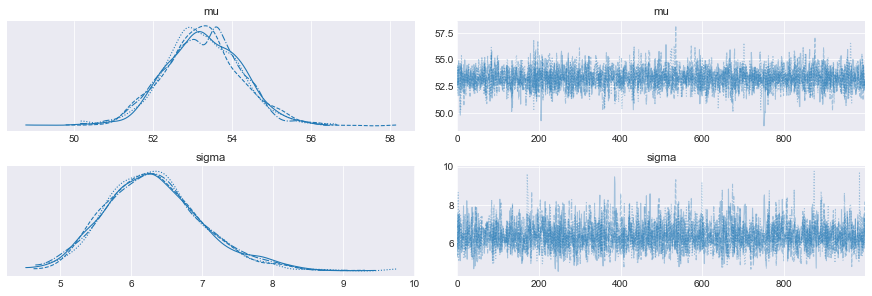

In [6]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd = 10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    trace_g = pm.sample(1100)
    
chain_g = trace_g[100:]
pm.traceplot(chain_g)

/Users/narenbao/anaconda3/envs/op/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0.5, 0, '$x$')

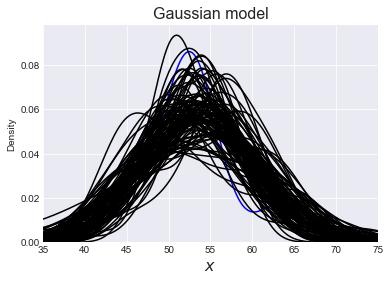

In [21]:
y_pred = pm.sample_posterior_predictive(chain_g, 100, model_g, size=len(data))
sns.kdeplot(data, c='b')
for i in y_pred['y']:
    sns.kdeplot(i[0], c='k', alpha=0.05)

plt.xlim(35, 75)
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)

In [22]:
tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


<AxesSubplot:xlabel='day', ylabel='tip'>

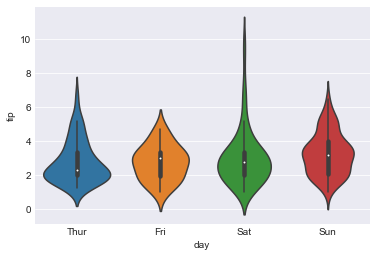

In [24]:
sns.violinplot(x='day', y='tip', data=tips)

In [34]:
#二つの変数を作る。tipの合計をyとし、カテゴリを表すダミー変数あるいはindexをidxとしまう。
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sds, means]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 9 seconds.
/Users/narenbao/anaconda3/envs/op/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


2


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'sds'}>,
        <AxesSubplot:title={'center':'sds'}>]], dtype=object)

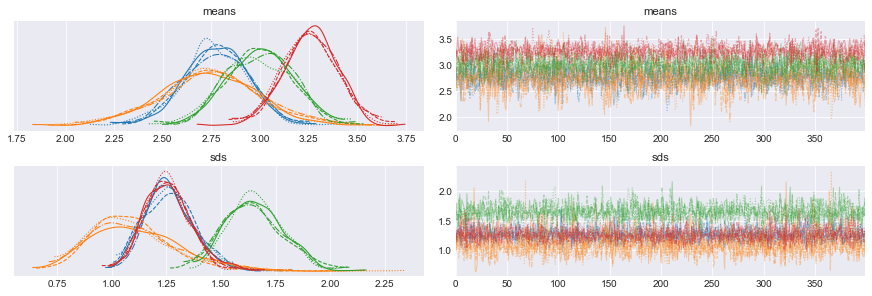

In [35]:
with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(idx)))
    y =pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    
    trace_cg = pm.sample(500)

chain_cg = trace_cg[100::]
pm.traceplot(chain_cg)

#### 階層モデル
都市における水質を分析したいとしましょう。年のあちこちの水域から採取したサンプルのデータを分析する方法は、以下の二つが考えられます。
-　各水域について、別々に水質変数を推定する
- 各水域のデータをプーリングし、一つの大きなグループとして都市の水質を推定する
階層モデルは事前分布に対して、さらに事前分布を設定するモデルです。

In [10]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1,0], [G_samples[i], N_samples[i] - G_samples[i]]))
print(data)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7055269826939261, but should be close to 0.8. Try to increase the number of tuning steps.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/Users/narenbao/anaconda3/envs/op/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

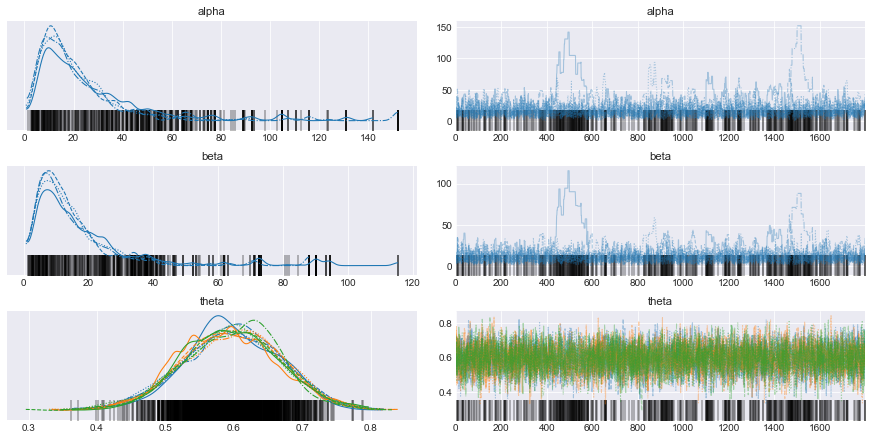

In [11]:
# \alpha~\beta_alpha
# \beta~\beta_beta
# \theta~alpha, beta
# y ~ 二項分布(\theta)

with pm.Model() as model_h:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    theta = pm.Beta('theta', alpha, beta, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)
    
    trace_h = pm.sample(2000)
chain_h = trace_h[200:]
pm.traceplot(chain_h)